Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [1]:
import pandas as pd
import ast
import torch
import torch.nn as nn
import transformers
from transformers import pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
import time
from huggingface_hub import login
import google.generativeai as genai
import os
from tqdm import tqdm
from datasets import Dataset
import json
from openai import OpenAI

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [2]:
df = pd.DataFrame()

###   SMALL DATASET   ###
df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

print(df.shape)


                                                text            timestamp  \
0                                      STI chiong ah  2020-05-14 12:35:30   
1  Look on the bright side - you'll never make th...  2020-02-09 17:23:24   
2  For posts flaired as such (by OP), we will be ...  2021-04-06 18:08:59   
3  sounds q fucked up if no concern for each othe...  2021-01-22 14:22:42   
4  Chinese media reported a while ago: https://ww...  2020-03-26 04:51:22   

         username                                               link  \
0       iamabear1  /r/singapore/comments/gjjem5/covid19_8663_busi...   
1          lkc159  /r/singapore/comments/f15aks/did_i_just_get_sc...   
2   AutoModerator  /r/singapore/comments/maajuo/a_compilation_of_...   
3       [deleted]  /r/singapore/comments/l28wfr/rsingapore_random...   
4  localinfluenza  /r/singapore/comments/fp5hgu/pcf_cluster_anoth...   

     link_id   parent_id       id subreddit_id  \
0  t3_gjjem5   t3_gjjem5  fqljinp     t5_2qh8c   
1  t

# Cleaning

In [3]:
df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
moderation_dicts = df['moderation']
moderation_normalized = pd.json_normalize(moderation_dicts)
# print(moderation_normalized)
df = df.reset_index(drop=True)
moderation_normalized = moderation_normalized.reset_index(drop=True)
df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
print(df_normalized.columns)

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
### removing deleted or removed text ###

### stop word removal ###
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    if isinstance(text, str):  # Check if the text is a string
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text 

df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
print(df_normalized['text'])
# print(stop_words)
### stop word removal ###

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'removal_reason', 'collapsed', 'collapsed_reason',
       'controversiality', 'author_is_blocked', 'collapsed_reason_code'],
      dtype='object')
0                                           STI chiong ah
1       Look bright side - never make mistake again, l...
2       posts flaired (by OP), exercising greater mode...
3                             sounds q fucked concern leh
4       Chinese media reported ago: https://www.zaobao...
                              ...                        
9994    Parents car workshop owners. Middle upper midd...
9995    Damn, Frostmourne sword going deadly spend day...
9997    need someone Microsoft Flight Sim 2020 fly Sin...
9998    wow ew, read said really don’t like guy. heck ...
9999    saying Chinese: 大义灭亲 (Remove kin greater good)...
Name: text, Length: 8970, dtype: object


In [4]:
print(df.columns)

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation'],
      dtype='object')


C:\Users\caboo\AppData\Local\Temp\ipykernel_27908\628181459.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not specified' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_for_plot.fillna('Not specified', inplace=True)


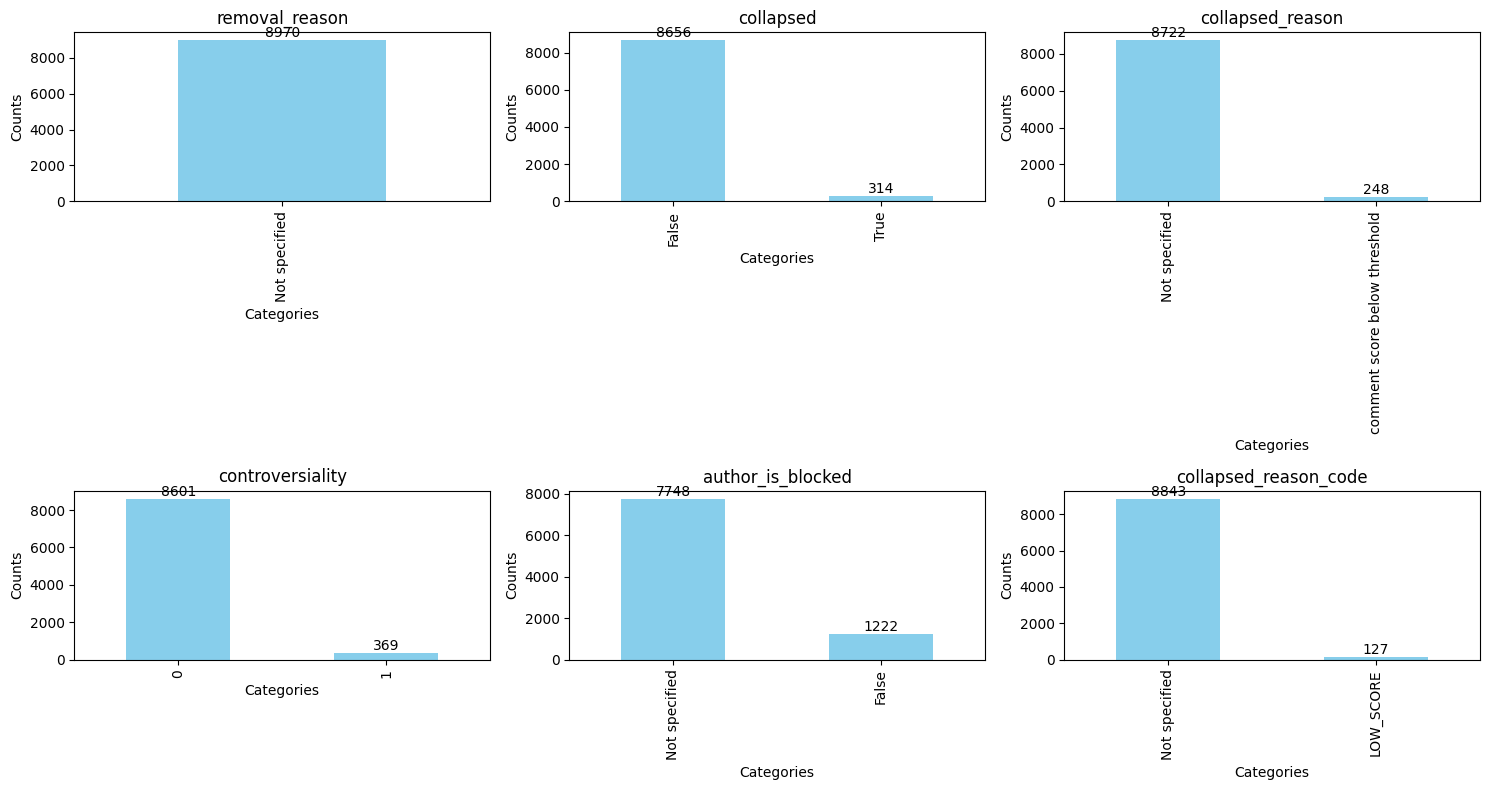

In [5]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


exclude_columns = [
    'text', 
    'timestamp', 
    'username', 
    'link', 
    'link_id', 
    'parent_id', 
    'id', 
    'subreddit_id'
]
columns_to_plot = [col for col in df_normalized.columns if col not in exclude_columns]


num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Using LLMs to label our data

## hugging face login

In [6]:
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')

login(token=hf_api_key)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful


In [7]:
def toxic_prompt(text):
    return(f"""Classify the following text as toxic or not toxic: 

1. Determine if the text is "True" or "False" for toxic content.

Text: "{text}"

Output True or False""")

def hate_prompt(text):
    return(f"""Classify the following text as hateful or not hateful: 

1. Determine if the text is "True" or "False" for hate content.

Text: "{text}"

Output True or False""")




## 2.1 hateBERT 

In [8]:
toxic_classifier = pipeline("text-classification", model="unitary/toxic-bert", return_all_scores=True, device=device)
hate_classifier = pipeline("text-classification", model="GroNLP/hateBERT", return_all_scores=True, device=device)

df_normalized['BERT_toxic'] = False
df_normalized['BERT_hateful'] = False

toxic_predictions = []
hate_predictions = []

# Iterate over the DataFrame and classify each text
for index, row in df_normalized.iterrows():
    # Get the text from the row
    text = row['text']

    # Use the toxicity classifier
    try:
        toxic_prediction = toxic_classifier(text, truncation=True)
        # Process the toxicity result
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            toxic_predictions.append((label, score))
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

    # Use the hatefulness classifier
    try:
        hate_prediction = hate_classifier(text, truncation=True)
        # Process the hatefulness result
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            hate_predictions.append((label, score))
            if label == 'LABEL_0' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_hateful'] = True
    except RuntimeError as e:
        print(f"Error processing hatefulness at index {index}: {e}")


print(df_normalized[['text', 'BERT_toxic', 'BERT_hateful']].head())

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_pro

                                                text  BERT_toxic  BERT_hateful
0                                      STI chiong ah       False          True
1  Look bright side - never make mistake again, l...       False          True
2  posts flaired (by OP), exercising greater mode...       False          True
3                        sounds q fucked concern leh        True          True
4  Chinese media reported ago: https://www.zaobao...       False          True


In [9]:
print(df_normalized['BERT_hateful'].value_counts())
print(df_normalized['BERT_toxic'].value_counts())
del toxic_classifier
del hate_classifier  
torch.cuda.empty_cache()  # Clear the cache again

BERT_hateful
True     8961
False       9
Name: count, dtype: int64
BERT_toxic
False    8301
True      669
Name: count, dtype: int64


## 2.2 Llama3.2
https://huggingface.co/meta-llama/Llama-3.2-1B

In [12]:
llama3_classifier = pipeline("text-classification", model="meta-llama/Llama-3.2-1B", device=device)

df_normalized['Llama3_toxic'] = False
df_normalized['Llama3_hate'] = False


for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    # Get the text from the row
    text = toxic_prompt(row['text'])

    # Use the toxicity classifier
    try:
        toxic_prediction = llama3_classifier(text, truncation=True)
        
        # Process the toxicity result
        score = toxic_prediction[0]['score']
        if score > 0.5:  # Adjust threshold as needed
            df_normalized.at[index, 'Llama3_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    # Get the text from the row
    text = hate_prompt(row['text'])

    # Use the toxicity classifier
    try:
        toxic_prediction = llama3_classifier(text, truncation=True)
        
        # Process the toxicity result
        score = toxic_prediction[0]['score'] 
        if score > 0.5:  # Adjust threshold as needed
            df_normalized.at[index, 'Llama3_hate'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

print(df_normalized[['text', 'Llama3_toxic']].head())
print(df_normalized[['text', 'Llama3_hate']].head())

del llama3_classifier 
torch.cuda.empty_cache()  


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying toxicity:   2%|▏         | 191/8970 [05:40<4:20:57,  1.78s/it]


KeyboardInterrupt: 

In [ ]:
print(df_normalized['llame3_toxic'].value_counts())
print(df_normalized['llame3_hate'].value_counts())

testing with datasets

In [15]:
llama3_classifier = pipeline("text-classification", model="meta-llama/Llama-3.2-1B", device=device)

dataset = Dataset.from_pandas(df_normalized)

# Add a prompt column to the dataset
dataset = dataset.map(lambda row: {"prompt": toxic_prompt(row['text'])})

# Batch classify the prompts
batch_size = 8  # Set batch size depending on your hardware capability
predictions = []
for i in tqdm(range(0, len(dataset), batch_size), desc="Classifying toxicity in batches"):
    batch = dataset['prompt'][i:i+batch_size]  # Select batch of prompts
    predictions.extend(llama3_classifier(batch, truncation=True))  # Classify the batch

# Process the predictions to extract the result
df_normalized['Llama3_toxic'] = [pred[0]['score'] > 0.5 for pred in predictions]  # Adjust threshold as needed

# Show results
print(df_normalized[['text', 'Llama3_toxic']].head())


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying toxicity in batches:   2%|▏         | 23/1122 [05:11<4:08:18, 13.56s/it]


KeyboardInterrupt: 

# 2.3 gemini?

In [43]:
genai.configure(api_key=os.getenv('GEMINI_API_KEY'))
model = genai.GenerativeModel("gemini-1.5-flash")
# responses = []
# for index, row in df_normalized.iterrows():
#     prompt = toxic_prompt(row['text'])
#     response = model.generate_content(prompt)
#     # response_text = response.text.strip()
#     import pdb; pdb.set_trace()
#     responses.append(response.text)
#     break

# print(responses)
# df_normalized['gemini_toxic'] = responses
# print(df_normalized[['text', 'gemini_toxic']].head())


response = model.generate_content(toxic_prompt("STI Chiong ah"))
response_text = response.text

print(response_text)

ValueError: ("Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 3. The candidate's safety_ratings are: [category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\n, category: HARM_CATEGORY_HATE_SPEECH\nprobability: MEDIUM\n, category: HARM_CATEGORY_HARASSMENT\nprobability: MEDIUM\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\n].", [category: HARM_CATEGORY_SEXUALLY_EXPLICIT
probability: NEGLIGIBLE
, category: HARM_CATEGORY_HATE_SPEECH
probability: MEDIUM
, category: HARM_CATEGORY_HARASSMENT
probability: MEDIUM
, category: HARM_CATEGORY_DANGEROUS_CONTENT
probability: NEGLIGIBLE
])

## 2.4 chatGPT 3.5
windows : setx OPENAI_API_KEY 'your_api_key'

apple/linux:
Export an envrionment variable on *nix systems
export OPENAI_API_KEY="your_api_key_here"

In [25]:
# openai_api_key = os.getenv('OPENAI_API_KEY')

client = OpenAI()

response = client.chat.completions.create(
  model = "gpt-4o-mini",
  response_format={ "type": "json_object" },
  messages = [
    {"role": "system", "content": "You are a funny comedian who tells dad jokes. The output should be in JSON format."},
  ]
)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}